In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, roc_auc_score, recall_score,
    precision_score, f1_score, RocCurveDisplay)
from imblearn.metrics import specificity_score

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re



from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier



import matplotlib.pyplot as plt


In [5]:
df_selftext = pd.read_csv('../../data/cleaned_selftext.csv')
df_notext = pd.read_csv('../../data/cleaned_notext.csv')
df_selftext.head(2)

,subreddit,text
0,0,using electric water boiler to mine bitcoin th...
1,0,btc to usdt hello i am looking to swap a good ...


In [6]:
print(df_selftext.subreddit.value_counts())
df_notext.subreddit.value_counts()

0    4017
1     787
Name: subreddit, dtype: int64


0    9938
1    2059
Name: subreddit, dtype: int64

# Adding stop words to not make it too easy

In [7]:
stop = list(stopwords.words('english'))
stop.extend('btc eth bitcoin ethereum lightning vitalik wa ha amp text would get llet like nt know one use think http'.split())


# Model

In [8]:
X = df_selftext.text
y = df_selftext.subreddit

In [9]:
y.value_counts(normalize=True)

0    0.836178
1    0.163822
Name: subreddit, dtype: float64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [11]:
# Pipeline accepts multiple transformers, but only one vectorizer. See cgpt results:

'''The error message is caused by the fact that you are trying to fit two different vectorizers (TfidfVectorizer and CountVectorizer) 
in the same pipeline, but only providing one input (X_train) to the pipeline. This is causing the pipeline to raise an error as it doesn't 
know which vectorizer to apply to the input. 

You can fix this by either removing one of the vectorizers or providing separate inputs to the pipeline for each vectorizer.'''


logr_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    #('cvec', CountVectorizer()),
    ('logr', LogisticRegression())
])

In [12]:
logr_pipe_params = {
    'tvec__max_features': range(600,800,5),
    'tvec__stop_words': [stop],
    'tvec__ngram_range': [(1,1), (1,2), (1,3),(2,3),(3,3)],
    'logr__C': [.01, .1 ,.5 , 1.0, 2, 5, 10]
    #'logr_penalty': ['l1', 'l2', 'elasticnet', None]
    #'cvec__max_features': range(2500, 3500, 100),
    #'cvec__min_df': range(1,5),
    #'cvec__max_df': [i/100 for i in range(0, 100, 5)],
    #'cvec__ngram_range': [(1,1),(1, 2), (1,3)]
}

In [13]:
rs = RandomizedSearchCV(logr_pipe, 
                  logr_pipe_params, 
                    cv = 5) 

In [14]:
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                             ('logr', LogisticRegression())]),
                   param_distributions={'logr__C': [0.01, 0.1, 0.5, 1.0, 2, 5,
                                                    10],
                                        'tvec__max_features': range(600, 800, 5),
                                        'tvec__ngram_range': [(1, 1), (1, 2),
                                                              (1, 3), (2, 3),
                                                              (3, 3)],
                                        'tvec__stop_words': [['i', 'me', 'my',
                                                              'myself', 'we',
                                                              'our', 'ours',
                                                              'ourselves',
                                                              'you',

In [15]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [16]:
#using all stopwords lowers scores to 0.8823747680890538 / 0.8654060066740823

print(rs.score(X_train, y_train))
rs.score(X_test, y_test)

0.9092422980849292


0.8942547876769359

In [17]:
#rs.best_params_

In [18]:
preds = rs.predict(X_test)

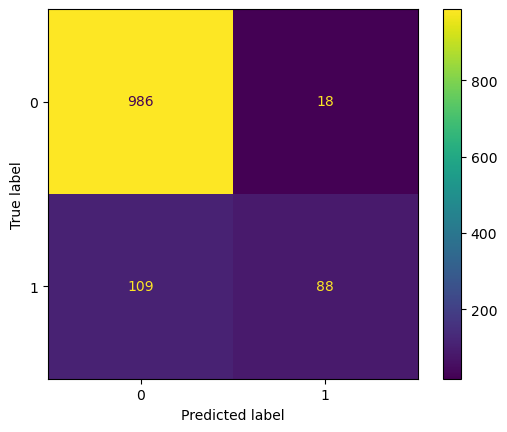

In [19]:
cm = confusion_matrix(y_test, preds)

display = ConfusionMatrixDisplay(confusion_matrix = cm,
                             display_labels = rs.classes_)

display.plot();

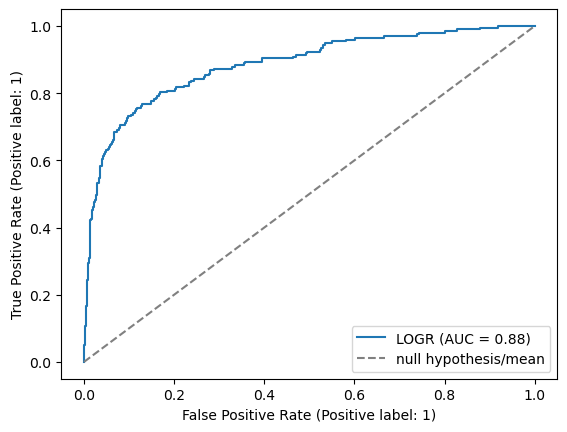

In [20]:
# Basic ROC

# cf ROC
# create an ax object
ax = plt.gca()

# use RocCurveDisplay for both estimators
RocCurveDisplay.from_estimator(rs, X_test, y_test, ax=ax, name='LOGR')

# add 'worst case scenario' line
plt.plot([0,1], [0,1], label='null hypothesis/mean', linestyle='--', color='gray')

# necessary to label the baseline
plt.legend();

# Preds analysis

In [21]:
pred_df = pd.DataFrame(rs.predict_proba(X_test),columns=['bitcoin', 'ethereum'])

pred_df['true_values'] = y_test.values

pred_df.head()


,bitcoin,ethereum,true_values
0,0.959717,0.040283,0
1,0.458805,0.541195,1
2,0.941398,0.058602,0
3,0.920313,0.079687,0
4,0.933723,0.066277,0


In [22]:
full_pred_df = pd.DataFrame(rs.predict_proba(X),columns=['bitcoin', 'ethereum'])

In [23]:
full_pred_df['true_values'] = y.values

full_pred_df.head()

,bitcoin,ethereum,true_values
0,0.984410,0.015590,0
1,0.952603,0.047397,0
2,0.934960,0.065040,0
3,0.974232,0.025768,0
4,0.975110,0.024890,0


In [24]:
df_selftext = df_selftext.join(full_pred_df)

In [25]:
df_selftext.sort_values(by = 'bitcoin')[0:100]

,subreddit,text,bitcoin,ethereum,true_values
4621,1,fifacup win we are li on pinksale presale time...,0.011689,0.988311,1
4793,1,polygon matic is not beneficial to ethereum an...,0.013675,0.986325,1
4043,1,idea fully decentralized pixel war with decent...,0.016126,0.983874,1
3342,0,manga token building the world's largest manga...,0.018095,0.981905,0
4105,1,upload mb vitalik's blog to a smart contract o...,0.024598,0.975402,1
...,...,...,...,...,...
4358,1,ml for detecting dodgy contract to me it seems...,0.149940,0.850060,1
4529,1,default metamask rpc log ip associated with et...,0.150007,0.849993,1
4580,1,presale smart contract hello eryone i would li...,0.150013,0.849987,1
4592,1,how doe usdt or chainlink bridging work i unde...,0.153591,0.846409,1


# Which bitcoin users are most susceptible to eth (or are we just modeling words)

In [26]:
df_selftext[(df_selftext.true_values == 1) & (df_selftext.bitcoin > .5)].sort_values(by = 'bitcoin', ascending = False)

,subreddit,text,bitcoin,ethereum,true_values
4622,1,anyone else ner heard of ftx or sbf just got t...,0.977078,0.022922,1
4494,1,mining guy what do you think of the innovation...,0.973381,0.026619,1
4393,1,selling eth same day in canada is there a way ...,0.971671,0.028329,1
4163,1,how optimism is hosted at etherscan subdomain ...,0.966025,0.033975,1
4647,1,would now be the time to buy and hold debating...,0.965975,0.034025,1
...,...,...,...,...,...
4187,1,delay attack on rollups in short their post ra...,0.507157,0.492843,1
4024,1,how big a role will the digital world play a t...,0.505955,0.494045,1
4402,1,what's the most cost effecti way to deploy a w...,0.505338,0.494662,1
4127,1,ethereum is stronger than it ha er been we mer...,0.503195,0.496805,1


In [27]:
#for i in df_selftext[(df_selftext.true_values == 1) & (df_selftext.bitcoin > .5)]['text']:
#    print(i, '\n')

# Eth posts with bitcoin flavor (False negatives)

In [28]:
bitcoinish_indexes = pred_df.loc[(pred_df['bitcoin'] > .5) & (pred_df.true_values == 1)].index.values.astype(int)

In [29]:
for i in df_selftext.iloc[bitcoinish_indexes].text:
    print(i,'\n')

i know i'll get roasted but is there anyone willing to allow me to borrow btc i gambled with the wrong people and now they are threatening me my family i had planned on getting it by today but it will be late tonight but for sure tomorrow i will pay anyone back who help me en if i ha to pay interest 

bitcoin superiority bitcoin superiorityi ha seen some argument here claiming bitcoin won't work and how visa is a better payment service this is obviously wrong to anyone who ha attended elementary school the name what sound cooler visa or lightning network one sound like something illegals use to sneak into my country the other sound like something the roman god posei rain down upon the poor people you cannot hide a visa card under a birdbath since plastic is biodegradeable community ha you er had a friend try to sell you on the virtue of visa ha you er gone to a pot luck with your visa buddy didnt think so ceo do you know the ceo of visa i certainly t know his name i assume it a man sin

In [30]:
#notes
def class_from_prob(probabilities, threshold):

    return [0 if prob < threshold else 1 for prob in probabilities]


In [31]:
threshold_list = [round(i*.01,2) for i in range(0,101,)]
speclist = []
senslist = []
f1list = []

for threshold in threshold_list:
    predicted_classes = class_from_prob(pred_df['ethereum'], threshold)
    spec = specificity_score(y_test, predicted_classes)
    sens = recall_score(y_test, predicted_classes, pos_label=1)
    speclist.append(spec)
    senslist.append(sens)
    F1 = f1_score(y_test, predicted_classes)
    f1list.append(F1)

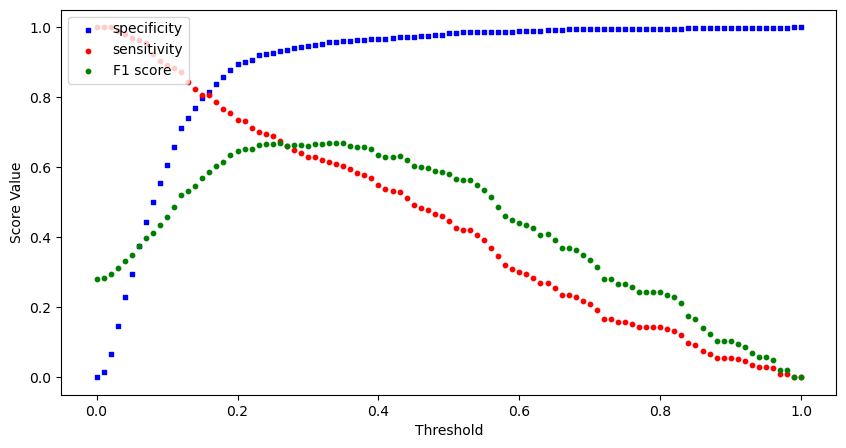

<Figure size 640x480 with 0 Axes>

In [32]:
%matplotlib inline
fig = plt.figure(figsize = (10,5));
ax1 = fig.add_subplot(111);

ax1.scatter(x = threshold_list, y = speclist, s=10, c='b', marker="s", label='specificity');
ax1.scatter(x = threshold_list,y = senslist, s=10, c='r', marker="o", label='sensitivity');
ax1.scatter(x = threshold_list,y = f1list, s=10, c='g', marker="o", label='F1 score');
plt.legend(loc='upper left')
plt.xlabel('Threshold');
plt.ylabel('Score Value');
plt.show();
plt.tight_layout();
